In [17]:
import numpy as np
import pandas as pd
import math

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split

# from sklearn.model_selection import train_test_split
from tqdm import tqdm
# import matplotlib.pyplot as plt



# Fetching the Dataset

### Upload kaggle.json

### Download BDB Dataset

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/daniel/.kaggle’: File exists


In [3]:
!kaggle competitions download -c nfl-big-data-bowl-2024

nfl-big-data-bowl-2024.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip nfl-big-data-bowl-2024.zip

Archive:  nfl-big-data-bowl-2024.zip
replace games.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Data Preprocessing

In [5]:
def get_tracking_and_plays(csv_name):
    """
    Return a dataframe containing cleaned tracking data joined with the plays data
    """
    tracking = pd.read_csv(csv_name)
    plays = pd.read_csv("plays.csv")
    tracking = tracking[tracking['playId'].isin(tracking[tracking['event'] != 'fumble']['playId'].unique())]
    plays = plays[plays['playNullifiedByPenalty'] == 'N']

    tracking.loc[tracking['playDirection'] == 'left', 'x'] = 120 - tracking.loc[tracking['playDirection'] == 'left', 'x']
    tracking.loc[tracking['playDirection'] == 'left', 'y'] = (160/3) - tracking.loc[tracking['playDirection'] == 'left', 'y']
    tracking.loc[tracking['playDirection'] == 'left', 'dir'] += 180
    tracking.loc[tracking['dir'] > 360, 'dir'] -= 360
    tracking.loc[tracking['playDirection'] == 'left', 'o'] += 180
    tracking.loc[tracking['o'] > 360, 'o'] -= 360

    tracking_with_plays = tracking.merge(plays, on=['gameId', 'playId'], how='left')

    tracking_with_plays['is_on_offense'] = tracking_with_plays['club'] == tracking_with_plays['possessionTeam']
    tracking_with_plays['is_on_defence'] = tracking_with_plays['club'] == tracking_with_plays['defensiveTeam']
    tracking_with_plays['is_ballcarrier'] = tracking_with_plays['ballCarrierId'] == tracking_with_plays['nflId']

    bc_coords=tracking_with_plays.loc[tracking_with_plays['is_ballcarrier']]
    bc_coords['bc_x']=bc_coords['x']
    bc_coords['bc_y']=bc_coords['y']
    bc_coords=bc_coords[['gameId', 'playId', 'frameId', 'bc_x', 'bc_y']]
    tracking_with_plays=tracking_with_plays.merge(bc_coords, on=['gameId', 'playId', 'frameId'], how='left')

    end_frame = tracking_with_plays[tracking_with_plays['event'].isin(['tackle', 'out_of_bounds'])].groupby(['gameId', 'playId'])['frameId'].min().reset_index()
    end_frame.rename(columns={'frameId': 'frameId_end'}, inplace=True)

    start_frame = tracking_with_plays[tracking_with_plays['event'].isin(['run', 'lateral', 'run_pass_option', 'handoff', 'pass_arrived'])].groupby(['gameId', 'playId'])['frameId'].min().reset_index()
    start_frame.rename(columns={'frameId': 'frameId_start'}, inplace=True)

    tracking_with_plays = tracking_with_plays.merge(start_frame, on=['gameId', 'playId'], how='left')
    tracking_with_plays = tracking_with_plays.merge(end_frame, on=['gameId', 'playId'], how='left')

    tracking_with_plays = tracking_with_plays[(tracking_with_plays['frameId'] <= tracking_with_plays['frameId_end']) &
                                              (tracking_with_plays['frameId'] >= tracking_with_plays['frameId_start'])]

    return tracking_with_plays

In [26]:
def compute_feature_df(tracking_with_plays):
    """
    Take in a dataframe of joined tracking and plays data. Compute per-frame features
    """
    # info = pd.DataFrame()
    # info_frames = []

    # for gid in tqdm(tracking_with_plays['gameId'].unique()):
    #     game = tracking_with_plays[tracking_with_plays['gameId'] == gid].copy()
    #     for pid in game['playId'].unique():
    #         try:
    #             play = game[game['playId'] == pid].copy()
    #             ball_carrier_id = play['ballCarrierId'].iloc[0]
    #             end_frame_id = play['frameId'].max()
    #             ball_end_x = play.loc[(play['frameId'] == end_frame_id) & (play['nflId'] == ball_carrier_id), 'x'].iloc[0]

    #             # Randomly select 40% of frames to keep
    #             # all_frame_ids = play['frameId'].unique()
    #             # selected_frame_ids = np.random.choice(all_frame_ids, size=int(len(all_frame_ids) * 0.3), replace=False)
    #             # play = play[play['frameId'].isin(selected_frame_ids)]

    #             for fid in play['frameId'].unique():
    #                 frame = play[play['frameId'] == fid].copy()
    #                 frame['is_on_offense'] = frame['club'] == frame['possessionTeam'].iloc[0]
    #                 frame['is_on_defense'] = frame['club'] == frame['defensiveTeam'].iloc[0]
    #                 frame['is_ball_carrier'] = frame['nflId'] == ball_carrier_id
    #                 frame['s_x'] = frame['s']*np.cos(np.deg2rad(frame['dir']))
    #                 frame['s_y'] = frame['s']*np.sin(np.deg2rad(frame['dir']))
    #                 frame['ball_carrier_s_x'] = frame.loc[frame['nflId'] == ball_carrier_id, 's_x'].iloc[0]
    #                 frame['ball_carrier_s_y'] = frame.loc[frame['nflId'] == ball_carrier_id, 's_y'].iloc[0]
    #                 frame['relative_s_x'] = frame['ball_carrier_s_x'] - frame['s_x']
    #                 frame['relative_s_y'] = frame['ball_carrier_s_y'] - frame['s_y']
    #                 frame['ball_carrier_x'] = frame.loc[frame['nflId'] == ball_carrier_id, 'x'].iloc[0]
    #                 frame['relative_x'] = frame['ball_carrier_x'] - frame['x']
    #                 frame['ball_carrier_y'] = frame.loc[frame['nflId'] == ball_carrier_id, 'y'].iloc[0]
    #                 frame['relative_y'] = frame['ball_carrier_y'] - frame['y']
    #                 frame['yards_remaining'] = ball_end_x - frame['ball_carrier_x']
    #                 info_frames.append(frame)
    #         except:
    #             print('error')
                
    # info = pd.concat(info_frames, ignore_index=True)
    # # info.to_csv('info.csv', index=False)
    # return info
    tensor_shape = (tracking_with_plays.groupby(['gameId', 'playId', 'frameId']).ngroups, 10, 11, 10)
    input_tensor = np.zeros(tensor_shape)
    target_tensor = np.zeros((tracking_with_plays.groupby(['gameId', 'playId', 'frameId']).ngroups))
    cur_count = 0
    for game_id, game_group in tqdm(tracking_with_plays.groupby('gameId')):
        for play_id, play_group in game_group.groupby('playId'):
            max_frame = play_group['frameId'].max()
            ball_end_x = play_group.loc[(play_group['frameId'] == max_frame) & (play_group['is_ballcarrier']), 'x']
            for frame_id, frame_group in play_group.groupby('frameId'):
                offense = frame_group[(frame_group['is_on_offense']) & (~frame_group['is_ballcarrier'])]
                defense = frame_group[frame_group['is_on_defence']]
                ballcarrier = frame_group[frame_group['is_ballcarrier']]
                ballcarrier_sx = ballcarrier.s * np.cos(np.deg2rad(ballcarrier.dir))
                ballcarrier_sy = ballcarrier.s * np.sin(np.deg2rad(ballcarrier.dir))
                for i, def_player in enumerate(defense.itertuples()):
                    def_player_sx = def_player.s * np.cos(np.deg2rad(def_player.dir))
                    def_player_sy = def_player.s * np.sin(np.deg2rad(def_player.dir))
                    for j, off_player in enumerate(offense.itertuples()):
                        off_player_sx = off_player.s * np.cos(np.deg2rad(off_player.dir))
                        off_player_sy = off_player.s * np.sin(np.deg2rad(off_player.dir))
                        input_tensor[cur_count, 0, i, j] = off_player.x - def_player.x
                        input_tensor[cur_count, 1, i, j] = off_player.y - def_player.y
                        input_tensor[cur_count, 2, i, j] = def_player_sx
                        input_tensor[cur_count, 3, i, j] = def_player_sy
                        input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
                        input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
                        input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
                        input_tensor[cur_count, 7, i, j] = def_player.y - ballcarrier.y
                        input_tensor[cur_count, 8, i, j] = off_player_sx - def_player_sx
                        input_tensor[cur_count, 9, i, j] = off_player_sy - def_player_sy
                        yards_remaining = ball_end_x.iloc[0] - ballcarrier.x
                        target_tensor[cur_count] = yards_remaining
                cur_count += 1
    return input_tensor, target_tensor

In [23]:
def create_feature_tensor_basic(feature_df):
    """
    Convert the input frame_df to a 4D tensor.
        - The first dimension is the frame
        - The second dimension is the index of the current player
        - The third dimension is the index of the relative player
    """
    tensor_shape = (feature_df.groupby(['gameId', 'playId', 'frameId']).ngroups, 11)
    input_tensor = np.zeros(tensor_shape)
    target_tensor = np.zeros((feature_df.groupby(['gameId', 'playId', 'frameId']).ngroups))
    cur_count = 0
    for gid in tqdm(feature_df['gameId'].unique()):
        game = feature_df[feature_df['gameId'] == gid]
        for play_id, play_group in game.groupby('playId'):
            for frame_id, frame_group in play_group.groupby('frameId'):
                #offense_players = frame_group[(frame_group['is_on_offense']) & (~frame_group['is_ball_carrier'])].head(10)
                defense_players = frame_group[frame_group['is_on_defense']].head(11)

                ballcarrier = frame_group[frame_group['is_ballcarrier']]
                # ballcarrier_sx = ballcarrier.s * np.cos(np.deg2rad(ballcarrier.dir))
                # ballcarrier_sy = ballcarrier.s * np.sin(np.deg2rad(ballcarrier.dir))
                for i, def_player in enumerate(defense_players.itertuples()):
                    input_tensor[cur_count, i] = ((def_player.x - ballcarrier.x)**2 + (def_player.y - ballcarrier.y)**2)**0.5
                    target_tensor[cur_count] = def_player.yards_remaining
                cur_count += 1

    return input_tensor, target_tensor

In [35]:
def create_feature_tensor(tracking_with_plays):
    """
    Convert the input frame_df to a 4D tensor.
        - The first dimension is the frame
        - The second dimension is the index of the current player
        - The third dimension is the index of the relative player
    """
    tensor_shape = (tracking_with_plays.groupby(['gameId', 'playId', 'frameId']).ngroups, 10, 11, 10)
    input_tensor = np.zeros(tensor_shape)
    target_tensor = np.zeros((tracking_with_plays.groupby(['gameId', 'playId', 'frameId']).ngroups))
    reference_tensor = np.zeros((tracking_with_plays.groupby(['gameId', 'playId', 'frameId']).ngroups, 3))
    cur_count = 0
    for game_id, game_group in tqdm(tracking_with_plays.groupby('gameId')):
        for play_id, play_group in game_group.groupby('playId'):
            max_frame = play_group['frameId'].max()
            ball_end_x = play_group.loc[(play_group['frameId'] == max_frame) & (play_group['is_ballcarrier']), 'x']
            for frame_id, frame_group in play_group.groupby('frameId'):
                offense = frame_group[(frame_group['is_on_offense']) & (~frame_group['is_ballcarrier'])]
                defense = frame_group[frame_group['is_on_defence']]
                ballcarrier = frame_group[frame_group['is_ballcarrier']]
                ballcarrier_sx = ballcarrier.s * np.cos(np.deg2rad(ballcarrier.dir))
                ballcarrier_sy = ballcarrier.s * np.sin(np.deg2rad(ballcarrier.dir))
                for i, def_player in enumerate(defense.itertuples()):
                    def_player_sx = def_player.s * np.cos(np.deg2rad(def_player.dir))
                    def_player_sy = def_player.s * np.sin(np.deg2rad(def_player.dir))
                    for j, off_player in enumerate(offense.itertuples()):
                        off_player_sx = off_player.s * np.cos(np.deg2rad(off_player.dir))
                        off_player_sy = off_player.s * np.sin(np.deg2rad(off_player.dir))
                        input_tensor[cur_count, 0, i, j] = off_player.x - def_player.x
                        input_tensor[cur_count, 1, i, j] = off_player.y - def_player.y
                        input_tensor[cur_count, 2, i, j] = def_player_sx
                        input_tensor[cur_count, 3, i, j] = def_player_sy
                        input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
                        input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
                        input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
                        input_tensor[cur_count, 7, i, j] = def_player.y - ballcarrier.y
                        input_tensor[cur_count, 8, i, j] = off_player_sx - def_player_sx
                        input_tensor[cur_count, 9, i, j] = off_player_sy - def_player_sy
                        yards_remaining = ball_end_x.iloc[0] - ballcarrier.x
                        target_tensor[cur_count] = yards_remaining
                        reference_tensor[cur_count, 0] = game_id
                        reference_tensor[cur_count, 1] = play_id
                        reference_tensor[cur_count, 2] = frame_id
                cur_count += 1
    return input_tensor, target_tensor, reference_tensor

### Visualization Helpers

In [14]:
def draw_histogram(tensor, num_bins=10):
    """
    Plots a histogram of the values in a 1D PyTorch tensor.

    Parameters:
    tensor (torch.Tensor): A 1D tensor containing the values to be plotted.
    num_bins (int): The number of bins to use for the histogram.
    """

    hist = torch.histc(tensor, bins=num_bins, min=float(tensor.min()), max=float(tensor.max()))
    bin_edges = torch.linspace(start=float(tensor.min()), end=float(tensor.max()), steps=num_bins+1)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0], align='edge')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Tensor Values')
    plt.show()

### Create Train and Test Sets

In [7]:
tracking_with_play_train = get_tracking_and_plays("tracking_week_1.csv")

In [10]:
tracking_with_plays_test = get_tracking_and_plays("tracking_week_2.csv")

In [8]:
feature_df_train = compute_feature_df(tracking_with_play_train)

100%|██████████| 16/16 [00:57<00:00,  3.62s/it]


In [12]:
feature_df_test = compute_feature_df(tracking_with_plays_test)

 12%|█▎        | 2/16 [00:06<00:48,  3.47s/it]

error


100%|██████████| 16/16 [00:55<00:00,  3.48s/it]


In [13]:
#feature_df.to_csv('week_1_feature_df.csv')

In [14]:
#!zip week_1_f.zip week_1_feature_df.csv

In [15]:
input_tensor, target_tensor = create_feature_tensor(feature_df_train)

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_22648/2312571209.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
/tmp/ipykernel_22648/2312571209.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
/tmp/ipykernel_22648/2312571209.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
/tmp/ipykernel_22648/2312571209.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 7, i, 

In [16]:
train_x, val_x, train_y, val_y = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=43)

In [19]:
test_x_tensor, test_y_tensor = create_feature_tensor(feature_df_test)

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_22648/2312571209.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
/tmp/ipykernel_22648/2312571209.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
/tmp/ipykernel_22648/2312571209.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
/tmp/ipykernel_22648/2312571209.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 7, i, 

In [38]:
train_x_arrays = []
train_y_arrays = []
for i in range(1,8):
    print(i)
    curx = np.load(f'week_{i}_x.npy')
    cury = np.load(f'week_{i}_y.npy')
    train_x_arrays.append(curx)
    train_y_arrays.append(cury)


train_x_tensor = np.concatenate(train_x_arrays)
train_y_tensor = np.concatenate(train_y_arrays)

1
2
3
4
5
6
7


In [39]:
test_x_arrays = []
test_y_arrays = []
for i in range(8,10):
    print(i)
    curx = np.load(f'week_{i}_x.npy')
    cury = np.load(f'week_{i}_y.npy')
    test_x_arrays.append(curx)
    test_y_arrays.append(cury)


test_x_tensor = np.concatenate(test_x_arrays)
test_y_tensor = np.concatenate(test_y_arrays)

8
9


In [37]:
test_y_arrays.shape

(32166,)

In [41]:
train_x = torch.tensor(train_x_tensor, dtype=torch.float)
train_y = torch.tensor(train_y_tensor, dtype=torch.float)
# val_x = torch.tensor(val_x, dtype=torch.float)
# val_y = torch.tensor(val_y, dtype=torch.float)
test_x = torch.tensor(test_x_tensor, dtype=torch.float)
test_y = torch.tensor(test_y_tensor, dtype=torch.float)

std_train = train_x.std()
mean_train = train_x.mean()

train_x = (train_x - mean_train) / std_train
# val_x = (val_x - mean_train) / std_train
test_x = (test_x - mean_train) / std_train

In [60]:
print(std_train)
print(mean_train)

tensor(6.8557)
tensor(-0.1061)


: 

In [43]:
train_y.shape

torch.Size([121112])

In [36]:
from numpy import save
def create_multiple_tensors(files):
    all_input_tensors = []
    all_target_tensors = []
    i = 1
    for c in files:
        print('Working on file ' + c)
        tracking_with_play_train = get_tracking_and_plays(c)
        #feature_df_train = compute_feature_df(tracking_with_play_train)
        input_tensor, target_tensor, reference_tensor = create_feature_tensor(tracking_with_play_train)
        print(input_tensor.shape)
        print(target_tensor.shape)
        all_input_tensors.append(input_tensor)
        all_target_tensors.append(target_tensor)
        np.save(f'week_{i}_x_new.npy', input_tensor)
        np.save(f'week_{i}_y_new.npy', target_tensor)
        np.save(f'week_{i}_r_new.npy', reference_tensor)
        i+=1
    #tracking_with_playsreturn np.stack(all_input_tensors, axis=0), torch.stack(all_target_tensors, axis=0)
        

In [37]:
create_multiple_tensors(['tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv','tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv'])
# np.save('train_x.npy', x)
# np.save('train_y.npy', y)

Working on file tracking_week_1.csv


/tmp/ipykernel_40043/3167614259.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_x']=bc_coords['x']
/tmp/ipykernel_40043/3167614259.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_y']=bc_coords['y']
100%|██████████| 16/16 [28:55<00:00, 108.45s/it]


(36959, 10, 11, 10)
(36959,)
Working on file tracking_week_2.csv


/tmp/ipykernel_40043/3167614259.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_x']=bc_coords['x']
/tmp/ipykernel_40043/3167614259.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_y']=bc_coords['y']
100%|██████████| 16/16 [28:38<00:00, 107.40s/it]


(36776, 10, 11, 10)
(36776,)
Working on file tracking_week_3.csv


/tmp/ipykernel_40043/3167614259.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_x']=bc_coords['x']
/tmp/ipykernel_40043/3167614259.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_y']=bc_coords['y']
100%|██████████| 16/16 [29:38<00:00, 111.18s/it]


(37616, 10, 11, 10)
(37616,)
Working on file tracking_week_4.csv


/tmp/ipykernel_40043/3167614259.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_x']=bc_coords['x']
/tmp/ipykernel_40043/3167614259.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_coords['bc_y']=bc_coords['y']
 44%|████▍     | 7/16 [12:45<15:46, 105.12s/it]

In [22]:
create_multiple_tensors(['tracking_week_8.csv', 'tracking_week_9.csv'])
# np.save('test_x.npy', x2)
# np.save('test_y.npy', y2)

Working on file tracking_week_8.csv


  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_31550/2312571209.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
/tmp/ipykernel_31550/2312571209.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
/tmp/ipykernel_31550/2312571209.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
/tmp/ipykernel_31550/2312571209.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 7, i, 

(17710, 10, 11, 10)
(17710,)
Working on file tracking_week_9.csv


  0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_31550/2312571209.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
/tmp/ipykernel_31550/2312571209.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
/tmp/ipykernel_31550/2312571209.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
/tmp/ipykernel_31550/2312571209.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 7, i, 

(14456, 10, 11, 10)
(14456,)


ValueError: all input arrays must have the same shape

In [ ]:
(val_x - mean_train) / std_train

tensor([[[[-1.5992e-01,  1.0371e-01, -8.5191e-03,  ..., -3.2467e-02,
            5.6873e-03,  1.7255e-02],
          [-3.5962e-01, -9.5990e-02, -2.0822e-01,  ..., -2.3217e-01,
           -1.9402e-01, -1.8245e-01],
          [-1.8955e-01,  7.4081e-02, -3.8150e-02,  ..., -6.2098e-02,
           -2.3943e-02, -1.2375e-02],
          ...,
          [-2.1634e-01,  4.7292e-02, -6.4939e-02,  ..., -8.8887e-02,
           -5.0733e-02, -3.9165e-02],
          [-3.2390e-01, -6.0271e-02, -1.7250e-01,  ..., -1.9645e-01,
           -1.5830e-01, -1.4673e-01],
          [-1.5850e-01,  1.0513e-01, -7.0985e-03,  ..., -3.1047e-02,
            7.1080e-03,  1.8676e-02]],

         [[ 7.5908e-02, -2.8002e-02,  2.2372e-03,  ...,  1.3253e-01,
            1.2867e-01,  8.0373e-02],
          [ 6.3122e-02, -4.0788e-02, -1.0549e-02,  ...,  1.1975e-01,
            1.1589e-01,  6.7587e-02],
          [ 1.3558e-01,  3.1665e-02,  6.1904e-02,  ...,  1.9220e-01,
            1.8834e-01,  1.4004e-01],
          ...,
     

In [ ]:
val_y.shape

torch.Size([3539])

In [ ]:
train_x.shape

torch.Size([14155, 10, 11, 10])

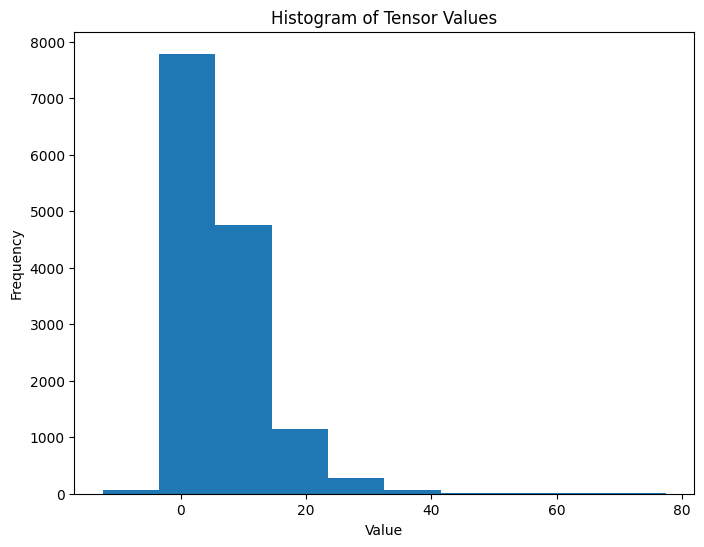

In [ ]:
draw_histogram(train_y)

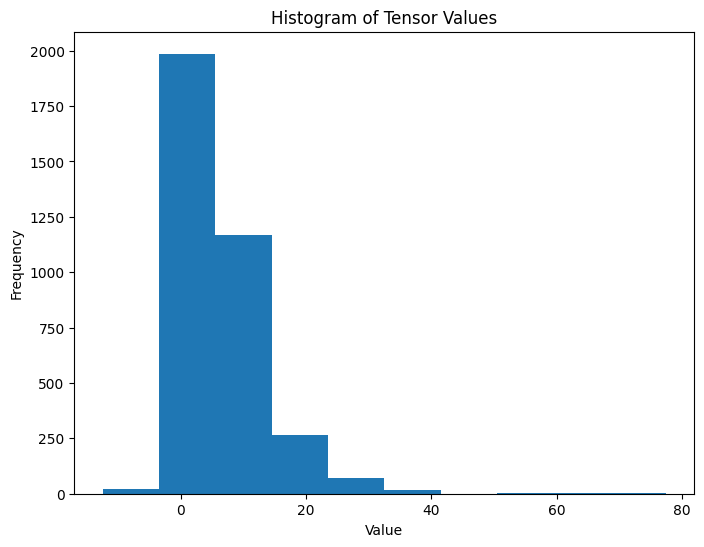

In [24]:
draw_histogram(val_y)

## Model Definitions

### Broken CNN

In [29]:
# Define the PyTorch model
class CNN2020(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=10, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        self.dense_1 = nn.Linear(96, 96)
        self.dense_2 = nn.Linear(96, 256)
        self.dense_3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.3)

        self.batchnorm_conv2d = nn.BatchNorm2d(128)
        self.batchnorm_conv1d = nn.BatchNorm1d(128)
        self.batchnorm_dense = nn.BatchNorm1d(96)
        self.batchnorm_flat = nn.BatchNorm1d(256)

    def forward(self, x):
        # Conv2D and Activation layers
        x = F.relu(self.conv2d_1(x))
        x = F.relu(self.conv2d_2(x))
        x = F.relu(self.conv2d_3(x))

        # MaxPooling2D and AvgPool2D layers
        xmax = F.max_pool2d(x, (1, 10)) * 0.3
        xavg = F.avg_pool2d(x, (1, 10)) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)
        #x = self.batchnorm_conv2d(x)

        # Reshape for Conv1D
        x = x.permute(0, 3, 1, 2).squeeze(1)

        # Conv1D and Activation layers

        x = F.relu(self.conv1d_1(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_2(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_3(x))
        #x = self.batchnorm_dense(x)

        # MaxPooling1D and AvgPool1D layers
        xmax = F.max_pool1d(x, 11) * 0.3
        xavg = F.avg_pool1d(x, 11) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)

        # Dense and Activation layers
        x = F.relu(self.dense_1(x))
        #x = self.batchnorm_dense(x)
        x = F.relu(self.dense_2(x))
        #x = self.batchnorm_flat(x)
        x = self.dense_3(x)
        x = torch.squeeze(x, 1)

        return x

In [44]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SqueezeExcitation, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        out = self.pool(x).view(b, c)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        out = out.view(b, c, 1, 1)
        return x * out

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class MatchupAttention(nn.Module):
    def __init__(self, in_channels):
        super(MatchupAttention, self).__init__()
        self.pooled = ChannelPool()
        self.compress = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(1, 1))
        self.matchups = nn.Linear(10, 10)
    def forward(self, x):
        pooled = self.pooled(x)
        x_compress = self.compress(pooled).squeeze(1)
        x_out = self.matchups(x_compress).unsqueeze(1)
        scale = F.sigmoid(x_out)
        #print(scale)
        return x * scale


# Define the PyTorch model
class SN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=10, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        self.dense_1 = nn.Linear(96, 96)
        self.dense_2 = nn.Linear(96, 256) #256
        self.dense_3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.2)

        self.batchnorm_conv2d = nn.BatchNorm2d(128)
        self.batchnorm_conv1d = nn.BatchNorm1d(128)
        self.batchnorm_dense = nn.BatchNorm1d(96)
        self.batchnorm_flat = nn.BatchNorm1d(256)

        # SE Blocks
        self.se_1 = SqueezeExcitation(128)
        self.se_2 = SqueezeExcitation(160)
        self.se_3 = SqueezeExcitation(128)

        # Matchup Attention Block
        self.ma_0 = MatchupAttention(10)
        self.ma_1 = MatchupAttention(128)
        self.ma_2 = MatchupAttention(160)
        self.ma_3 = MatchupAttention(128)

    def forward(self, x):
        # Conv2D and Activation layers
        #x = self.ma_0(x)
        x = F.relu(self.conv2d_1(x))
        x = self.se_1(x)
        x = self.ma_1(x)
        x = self.dropout(x)
        x = F.relu(self.conv2d_2(x))
        x = self.se_2(x)
        x = self.ma_2(x)
        x = self.dropout(x)
        x = F.relu(self.conv2d_3(x))
        x = self.se_3(x)
        x = self.ma_3(x)
        x = self.dropout(x)
        # Matchup Attention
        
        
        # MaxPooling2D and AvgPool2D layers
        xmax = F.max_pool2d(x, (1, 10)) * 0.3
        xavg = F.avg_pool2d(x, (1, 10)) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)
        #x = self.batchnorm_conv2d(x)

        # Reshape for Conv1D
        x = x.permute(0, 3, 1, 2).squeeze(1)

        # Conv1D and Activation layers

        x = F.relu(self.conv1d_1(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_2(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_3(x))
        #x = self.batchnorm_dense(x)

        # MaxPooling1D and AvgPool1D layers
        xmax = F.max_pool1d(x, 11) * 0.3
        xavg = F.avg_pool1d(x, 11) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)

        # Dense and Activation layers
        x = F.relu(self.dense_1(x))
        #x = self.dropout(x)
        #x = self.batchnorm_dense(x)
        x = F.relu(self.dense_2(x))
        #x = self.dropout(x)
        #x = self.batchnorm_flat(x)
        x = self.dense_3(x)
        x = torch.squeeze(x, 1)

        return x

In [63]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SqueezeExcitation, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dense1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.dense2 = nn.Linear(in_channels // reduction_ratio, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        out = self.pool(x).view(b, c)
        out = F.relu(self.dense1(out))
        out = torch.sigmoid(self.dense2(out))
        out = out.view(b, c, 1, 1)
        return x * out

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class MatchupAttention(nn.Module):
    def __init__(self, in_channels):
        super(MatchupAttention, self).__init__()
        self.pooled = ChannelPool()
        self.compress = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(1, 1))
        self.matchups = nn.Linear(10, 10)
    def forward(self, x):
        pooled = self.pooled(x)
        x_compress = self.compress(pooled).squeeze(1)
        x_out = self.matchups(x_compress).unsqueeze(1)
        scale = F.sigmoid(x_out)
        #print(scale)
        return x * scale

# Define the PyTorch model
class SN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=10, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        self.dense_1 = nn.Linear(96, 96)#256
        self.dense_2 = nn.Linear(96, 512)
        self.dense_3 = nn.Linear(512, 512)
        self.dense_4 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.2)

        self.batchnorm_conv2d = nn.BatchNorm2d(128)
        self.batchnorm_conv1d = nn.BatchNorm1d(128)
        self.batchnorm_dense = nn.BatchNorm1d(96)
        self.batchnorm_flat = nn.BatchNorm1d(256)

        # SE Blocks
        self.se_1 = SqueezeExcitation(128)
        self.se_2 = SqueezeExcitation(160)
        self.se_3 = SqueezeExcitation(128)

        # Matchup Attention Block
        self.ma_0 = MatchupAttention(10)
        self.ma_1 = MatchupAttention(128)
        self.ma_2 = MatchupAttention(160)
        self.ma_3 = MatchupAttention(128)

    def forward(self, x):
        # Conv2D and Activation layers
        #x = self.ma_0(x)
        x = F.relu(self.conv2d_1(x))
        #x = self.se_1(x)
        x = self.ma_1(x)
        x = self.dropout(x)
        x = F.relu(self.conv2d_2(x))
        #x = self.se_2(x)
        x = self.ma_2(x)
        x = self.dropout(x)
        x = F.relu(self.conv2d_3(x))
        #x = self.se_3(x)
        x = self.ma_3(x)
        x = self.dropout(x)
        # Matchup Attention
        
        
        # MaxPooling2D and AvgPool2D layers
        xmax = F.max_pool2d(x, (1, 10)) * 0.3
        xavg = F.avg_pool2d(x, (1, 10)) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)
        #x = self.batchnorm_conv2d(x)

        # Reshape for Conv1D
        x = x.permute(0, 3, 1, 2).squeeze(1)

        # Conv1D and Activation layers

        x = F.relu(self.conv1d_1(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_2(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_3(x))
        #x = self.batchnorm_dense(x)

        # MaxPooling1D and AvgPool1D layers
        xmax = F.max_pool1d(x, 11) * 0.3
        xavg = F.avg_pool1d(x, 11) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)

        # Dense and Activation layers
        x = F.relu(self.dense_1(x))
        #x = self.dropout(x)
        #x = self.batchnorm_dense(x)
        x = F.relu(self.dense_2(x))
        x = F.relu(self.dense_3(x))
        #x = self.dropout(x)
        #x = self.batchnorm_flat(x)
        x = self.dense_4(x)
        x = torch.squeeze(x, 1)

        return x

### New CNN

In [39]:
# Define the PyTorch model
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=8, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=10, out_channels=96, kernel_size=11, stride=1, padding=5)
        self.conv1d_2 = nn.Conv1d(in_channels=96, out_channels=128, kernel_size=11, stride=1, padding=5)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=98, kernel_size=11, stride=1, padding=5)
        self.conv1d_4 = nn.Conv1d(in_channels=98, out_channels=10, kernel_size=11, stride=1)
        self.dense_1 = nn.Linear(110, 1000)
        self.dense_2 = nn.Linear(1000, 256)
        self.dense_3 = nn.Linear(256, 1)

        # self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        # self.dense_1 = nn.Linear(96, 96)
        # self.dense_2 = nn.Linear(96, 256)
        # self.dense_3 = nn.Linear(256, 1)

        # self.batchnorm_conv2d = nn.BatchNorm2d(128)
        # self.batchnorm_conv1d = nn.BatchNorm1d(128)
        # self.batchnorm_dense = nn.BatchNorm1d(96)
        # self.batchnorm_flat = nn.BatchNorm1d(256)
3
    def forward(self, ipt):
        # Conv2D and Activation layers
        x = F.leaky_relu(self.conv2d_1(ipt))
        x = F.leaky_relu(self.conv2d_2(x))
        x = F.leaky_relu(self.conv2d_3(x))
        x = F.leaky_relu(self.conv2d_4(x))
        x = torch.flatten(x, start_dim=1)
        # x = x.squeeze(1)
        # x = x.permute(0, 2, 1).squeeze(1)
        # x = F.leaky_relu(self.conv1d_1(x))
        # x = F.leaky_relu(self.conv1d_2(x))
        # x = F.leaky_relu(self.conv1d_3(x))
        # x = F.leaky_relu(self.conv1d_4(x))
        # x = x.squeeze(2)
        x = F.leaky_relu(self.dense_1(x))
        x = F.leaky_relu(self.dense_2(x))
        x = self.dense_3(x)


        return x

In [ ]:
# dule):
#     def __init__(self):
#         super(BasicCNN, self).__init__()
#         self.conv2d_1 = nn.Conv2d(in_channels=8, out_channels=128, kernel_size=(1, 1))
#         self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
#         self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
#         self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

#         self.conv1d_1 = nn.Conv1d(in_channels=10, out_channels=96, kernel_size=11, stride=1, padding=5)
#         self.conv1d_2 = nn.Conv1d(in_channels=96, out_channels=128, kernel_size=11, stride=1, padding=5)
#         self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=98, kernel_size=11, stride=1, padding=5)
#         self.conv1d_4 = nn.Conv1d(in_channels=98, out_channels=10, kernel_size=11, stride=1)
#         self.dense_1 = nn.Linear(110, 1000)
#         self.dense_2 = nn.Linear(1000, 256)
#         self.dense_3 = nn.Linear(256, 1)

#         # self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
#         # self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
#         # self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)
x = F.relu(self.dense_2(x))nv2d = nn.BatchNorm2d(128)
#         # self.batchnorm_conv1d = nn.BatchNorm1d(128)
#         # self.batchnorm_dense = nn.BatchNorm1d(96)
#         # self.batchnorm_flat = nn.BatchNorm1d(256)

#     def forward(self, ipt):
#         # Conv2D and Activation layers
#         x = F.leaky_relu(self.conv2d_1(ipt))
#         x = F.leaky_relu(self.conv2d_2(x))
#         x = F.leaky_relu(self.conv2d_3(x))
#         x = F.leaky_relu(self.conv2d_4(x))
#         x = torch.flatten(x, start_dim=1)
#         # x = x.squeeze(1)
#         # x = x.permute(0, 2, 1).squeeze(1)
#         # x = F.leaky_relu(self.conv1d_1(x))
#         # x = F.leaky_relu(self.conv1d_2(x))
#         # x = F.leaky_relu(self.conv1d_3(x))
#         # x = F.leaky_relu(self.conv1d_4(x))
#         # x = x.squeeze(2)
#         x = F.leaky_relu(self.dense_1(x))
#         x = F.leaky_relu(self.dense_2(x))
#         x = self.dense_3(x)


#         return x

In [40]:
# Define the PyTorch model
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=10, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=10, out_channels=1, kernel_size=11, stride=1)
        self.dense_3 = nn.Linear(110, 1000)
        self.dense_4 = nn.Linear(1000, 1000)
        self.dense_5 = nn.Linear(1000, 1)
        self.relu = nn.SiLU()

    def forward(self, x):
        # Conv2D and Activation layers
        x = self.relu(self.conv        x = F.relu(self.conv2d_3(x))
2d_1(x))
        x = self.relu(self.conv2d_2(x))
        x 
        x = self.ma_2(x)= self.relu(self.conv2d_3(x))
        x = self.relu(self.conv2d_4(x))
        x = torch.flatten(x, 1)
        # print(x)
        # x = x.squeeze(1)
        # x = x.permute(0, 2, 1).squeeze(1)

        # x = F.leaky_relu(self.conv1d_1(x))

        # x= x.squeeze(1)
        x = self.relu(self.dense_3(x))
        x = self.relu(self.dense_4(x))
        x = self.dense_5(x)
        return x

In [73]:
# Define the PyTorch model
class Basic(nn.Module):
    def __init__(self):
        super(Basic, self).__init__()
        self.dense_1 = nn.Linear(11, 100)
        self.dropout = nn.Dropout(p=0.2)
        self.dense_2 = nn.Linear(100, 200)
        self.dense_3 = nn.Linear(100, 1)
        self.relu = nn.SiLU()

    def forward(self, x):
        # Conv2D and Activation layers
        x = self.dropout(self.relu(self.dense_1(x)))
        x = self.dense_3(x)
        x = torch.squeeze(x, 1)
        return x

In [42]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
        se
        x = self.ma_2(x)lf.relu = nn.SiLU()
    def forward(self, l, g):
        #print(in_features_g)
        N, C, W, H = l.shape
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        #print(g_.shape)
        c = self.phi(self.relu(l_ + g_)) # batch_sizex1xWxH
        #print(c.shape)nn.Dropout(p=0.2)
        if self.normalize_attn:
            a = (c.view(N,1,-1)).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1) # weighted sum
        else:
            output = nn.AdaptiveAvgPool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

# Define the PyTorch model
class Skynet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv21 = nn.Conv2d(256,512,1,stride = 1)
        self.conv22 = nn.Conv2d(512, 256, 1,stride = 1)
        self.conv23 = nn.Conv2d(256,128, 1,stride = 1)
        self.conv24 = nn.Conv2d(8,128,1,stride = 1)
        se
        x = self.ma_2(x)lf.conv25 = nn.Conv2d(128, 256, 1,stride = 1)
        self.conv26 = nn.Conv2d(256,128, 1,stride = 1)

        self.dconv21 = nn.Conv2d(10,128,1,stride = 1)
        self.dconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.dconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.oconv21 = nn.Conv2d(10,128,1,stride = 1)
        self.oconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.oconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.poolmax2 = nn.MaxPool2d(1,5)
        self.poolavg2 = nn.AvgPool2d(1,5)

        self.poolmax1 = nn.MaxPool1d(1,5)
        self.poolavg1 = nn.AvgPool1d(1,5)
        self.batch1 = nn.BatchNorm1d(2)

        self.conv11 = nn.Conv1d(2,128,1)
        self.batch2 = nn.BatchNorm1d(128)
        self.conv12 = nn.Conv1d(128,160,1)
        self.batch3 = nn.BatchNorm1d(160)
        nn.Dropout(p=0.2)self.conv13 = nn.Conv1d(160,96,1)
        self.batch4 = nn.BatchNorm1d(96)

        self.attentionmech = AttentionBlock(8, 128, 256, 4, normalize_attn=True)
        self.fc1 = nn.Linear(2112,512)
        self.fc2 = nn.Linear(512,256)
        self.batch6 = nn.BatchNorm1d(512)
        self.batch5 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,1)
        #self.squeeze = torch.squeeze(1)
        self.relu = nn.SiLU()

    def forward(self,x):
        temp = x
        dfence = x[:,:,:,:11]
        ofence = x[:,:,:,11:]

        dfence = self.relu(self.dconv21(dfence))
        dfence = self.relu(self.dconv22(dfence))
        dfence = self.relu(self.dconv23(dfence))

        ofence = self.relu(self.oconv21(ofence))
        ofence = self.relu(self.oconv22(ofence))
        ofence = self.relu(self.oconv23(ofence))

        x = self.relu(self.conv24(x))
        x = self.relu(self.conv25(x))
        x = self.relu(self.conv26(x))

        #print(ofence.shape,dfence.shape)
        x = torch.cat((torch.cat((dfence,ofence),dim = 3),x),dim = 1)
        #print(x.shape)
        #print(temp.shape)class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )
        #x = torch.cat((dfence,ofence),dim = 3)

        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.relu(self.conv23(x))

        attention, x = self.attentionmech(temp,x)
        xmax = self.poolmax2(x)
       
 xavg = self.poolavg2(x)
        x = 0.3*xmax + 0.7*xavg
        #print(x.shape)

        #x = torch.flatten(x,start_dim=2,end_dim=3)
        x = self.batch1(x)
        x = self.relu(self.conv11(x))
        x = self.batch2(x)
        x = self.relu(self.conv12(x))
        x = self.batch3(x)
        x = self.relu(self.conv13(x))
        x = self.batch4(x)
        xmax = self.poolmax1(x)
        xavg = self.poolavg1(x)
        x = 0.3*xmax + 0.7*xavg
        x = torch.flatten(x,start_dim=1,end_dim=2)
        #print(x.shape)

        x = self.relu(self.fc1(x))
        #print(x.mT.shape)
        x = self.batch6(x)        # x = self.se_3(x)
        # x = self.ma_3(x)
        # x = self.dropout(x)

In [43]:
# Define the PyTorch model
class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=8, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=11, stride=1)
        se
        x = self.ma_2(x)lf.dense_1 = nn.Linear(10, 1000)
        self.dense_2 = nn.Linear(1000, 256)
        self.dense_3 = nn.Linear(880, 1)
     x = torch.flatten(x, start_dim=1)
        # self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        # self.dense_1 = nn.Linear(96, 96)
        # self.dense_2 = nn.Linear(96, 256)
        # self.dense_3 = nn.Linear(256, 1)

        # self.batchnorm_conv2d = nn.BatchNorm2d(128)
        # self.batchnorm_conv1d = nn.BatchNorm1d(128)
        # self.batchnorm_dense = nn.BatchNorm1d(96)
        # self.batchnorm_flat = nn.BatchNorm1d(256)

    def forward(self, x):
        # # Conv2D and Activation layers
        # x = F.relu(self.conv2d_1(x))
        #t x = F.relu(self.conv2d_2(x))
        # x = F.relu(self.conv2d_3(x))

        # # MaxPooling2D and AvgPool2D layers
        # xmax = F.max_pool2d(x, (1, 10)) * 0.3
        # xavg = F.avg_pool2d(x, (1, 10)) * 0.7
        # x = xmax + xavg
        # x = torch.squeeze(x, 2)
        # x = self.batchnorm_conv2d(x)

        # # Reshape for Conv1D
        # x = x.permute(0, 3, 1, 2).squeeze(1)

        # # Conv1D and Activation layers

        #t x = F.relu(self.conv1d_1(x))
        # x = self.batchnorm_conv1d(x)
        # x = F.relu(self.conv1d_2(x))
        # x = self.batchnorm_conv1d(x)
        # x = F.relu(self.conv1d_3(x))
        # x = self.batchnorm_dense(x)

        # # MaxPooling1D and AvgPool1D layers
        # xmax = F.max_pool1d(x, 11) * 0.3
        # xavg = F.avg_pool1d(x, 11) * 0.7
        # x = xmax + xavg
        # x =nn.Dropout(p=0.2)lf.dense_3(x)


        return x

# Training Pipeline

### Create dataloaders to support batched training

In [45]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [27]:
val_y.shape

torch.Size([3539])

In [46]:
def accuracy_within_one(y_pred, y_true):
    """
    Computes accuracy where a prediction is considered correct if it is within ±1 of the actual value.

    Parameters:
    y_pred (torch.Tensor): The predicted values.
    y_true (torch.Tensor): The actual values.

    Retx_compressurns:
        
        # Matchup Attention
        
                # x = self.se_3(x)
        # x = self.ma_3(x)
        # x = self.dropout(x)
        # MaxPooling2D and AvgPool2D layers
        xmax = F.max_pool2d(x, (1, 10)) 
    float: The accuracy of the predictions within a range of ±1.
    """
    # Ensure that y_pred and y_true are both tensors
    if not isinstance(y_pred, torch.Tensor):
        y_pred = torch.tensor(y_pred)
    if not isinstance(y_true, torch.Tensor):
        y_true = torch.tensor(y_true)
    # Calculate the absolute difference
    diff = torch.abs(y_pred - y_true)

    # Count how many predictions are within ±1
    correct = torch.sum(diff <= 1.0)
    # Calculate the accuracy
    accuracy = correct.item() / len(y_pred)
    return accuracy

### Training loop

In [33]:
model = CNN2()
print(model)

NameError: name 'CNN2' is not defined

In [34]:
for x, y in val_loader:
    print(y[0])
    print(y[0])
    print(x[0])
    print(x[0])
    break

tensor(10.1900)
tensor(10.1900)
tensor([[[-0.4012, -0.2586, -0.7777,  ..., -0.5339, -0.1660, -0.2301],
         [-0.8676, -0.7250, -1.2440,  ..., -1.0002, -0.6323, -0.6964],
         [-0.3528, -0.2102, -0.7292,  ..., -0.4854, -0.1175, -0.1816],
         ...,
         [-0.7150, -0.5724, -1.0915,  ..., -0.8476, -0.4797, -0.5439],
         [-0.8248, -0.6822, -1.2013,  ..., -0.9574, -0.5895, -0.6537],
         [-1.2569, -1.1143, -1.6334,  ..., -1.3895, -1.0216, -1.0858]],

        [[-0.2415, -0.6950, -0.9374,  ..., -0.4840, -0.9232, -1.1456],
         [ 0.2747, -0.1788, -0.4212,  ...,  0.0323, -0.4070, -0.6294],
         [ 1.4526,  0.9991,  0.7567,  ...,  1.2102,  0.7710,  0.5485],
         ...,
         [ 1.0947,  0.6412,  0.3988,  ...,  0.8522,  0.4130,  0.1906],
         [ 0.5913,  0.1378, -0.1046,  ...,  0.3489, -0.0904, -0.3128],
         [-0.4184, -0.8718, -1.1143,  ..., -0.6608, -1.1000, -1.3225]],

        [[ 0.0068,  0.0068,  0.0068,  ...,  0.0068,  0.0068,  0.0068],
         [-0.

In [35]:
for x, y in train_loader:
    print(y[0])
    print(x[0])
    break

tensor(16.0800)
tensor([[[-2.3155e-01, -2.0018e-01,  2.3049e-01,  ..., -1.6167e-01,
           3.7737e-01, -9.6075e-02],
         [-3.6702e-01, -3.3565e-01,  9.5016e-02,  ..., -2.9715e-01,
           2.4190e-01, -2.3155e-01],
         [-3.6181e-02, -4.8074e-03,  4.2586e-01,  ...,  3.3696e-02,
           5.7274e-01,  9.9294e-02],
         ...,
         [-1.0444e+00, -1.0130e+00, -5.8236e-01,  ..., -9.7452e-01,
          -4.3547e-01, -9.0892e-01],
         [-1.5739e-01, -1.2602e-01,  3.0465e-01,  ..., -8.7518e-02,
           4.5153e-01, -2.1920e-02],
         [-1.0606e-01, -7.4684e-02,  3.5598e-01,  ..., -3.6181e-02,
           5.0287e-01,  2.9418e-02]],

        [[ 4.7956e-02, -1.8449e-01,  4.0067e+00,  ..., -3.1141e-01,
          -6.5651e-01,  2.0910e-01],
         [-5.6239e-01, -7.9484e-01,  3.3963e+00,  ..., -9.2176e-01,
          -1.2669e+00, -4.0125e-01],
         [ 9.0738e-02, -1.4171e-01,  4.0495e+00,  ..., -2.6863e-01,
          -6.1373e-01,  2.5188e-01],
         ...,
         

In [36]:
for name, parameter in model.named_parameters():
    parameter.requires_grad = True

NameError: name 'model' is not defined

In [72]:
test_y.shape

torch.Size([17226])

In [51]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs = 10
model = SN2()
# for name, parameter in model.named_parameters():
#     parameter.requires_grad = True

layer_gradients = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)
criterion = nn.L1Loss()
# Train the model for <epochs> epochs     x = torch.flatten(x, start_dim=1)
layer_gradients = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        # print(batch_x[0])
        # x[1] = x[1] * 0
        # print(x)
        optimizer.zero_grad()
        outputs = model(batch_x)
        # print(outputs)
        # print(batch_y)
        loss = criterion(outputs, batch_y)
        loss.backward()

        cur_layer_gradients = []
        for name, parameter in model.named_parameters():
            if parameter.grad is not None:
                # Compute the average of the absolute gradients for this layer
                avg_grad = parameter.grad.abs().mean()
                layer_gradients.append((name, avg_grad))
        layer_gradients.append(cur_layer_gradients)
        optimizer.step()

        # print("outputs")
        # print(outputs)
        # print("targets")
        # print(batch_y)
        train_loss += loss.item()
    train_loss /= len(train_loader)
    #Valudation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for cur_val_x, cur_val_y in val_loader:
            val_outputs = model(cur_val_x)
            val_acc += accuracy_within_one(val_outputs, cur_val_y)
            val_loss += criterion(val_outputs, cur_val_y).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

    print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

Epoch 0, Train Loss: 3.3192993059813425, Validation Loss: 2.9422826661229546, Validation Accuracy: 0.40054699154649426
Epoch 1, Train Loss: 3.025956912372197, Validation Loss: 2.941791746270769, Validation Accuracy: 0.4052606497596552
Epoch 2, Train Loss: 2.9562474652987016, Validation Loss: 2.900143486937144, Validation Accuracy: 0.40151044256588764
Epoch 3, Train Loss: 2.92028651461891, Validation Loss: 2.8461516080160214, Validation Accuracy: 0.42211586275484836
Epoch 4, Train Loss: 2.89461833583474, Validation Loss: 2.857814402262528, Validation Accuracy: 0.404100364661031
Epoch 5, Train Loss: 2.881197665318788, Validation Loss: 3.0965929720634136, Validation Accuracy: 0.3356435438422012
Epoch 6, Train Loss: 2.8653034971994957, Validation Loss: 2.800195871753695, Validation Accuracy: 0.4096842366981601
Epoch 7, Train Loss: 2.848722622613453, Validation Loss: 2.8077127132870436, Validation Accuracy: 0.426715564395823
Epoch 8, Train Loss: 2.8506632023868663, Validation Loss: 2.820916

In [ ]:
"""
Epoch 0, Train Loss: 3.821626317433718, Validation Loss: 4.131088550763764, Validation Accuracy: 0.33530640668523676
Epoch 1, Train Loss: 3.326458682044078, Validation Loss: 3.381920945068809, Validation Accuracy: 0.37952646239554316
Epoch 2, Train Loss: 3.206917774677277, Validation Loss: 3.5517562342636433, Validation Accuracy: 0.376102599814299
Epoch 3, Train Loss: 3.164992877453734, Validation Loss: 3.2613160067282014, Validation Accuracy: 0.37180826369545034
Epoch 4, Train Loss: 3.082889634875928, Validation Loss: 3.2162878507525146, Validation Accuracy: 0.39641364902506965
Epoch 5, Train Loss: 3.0322216829337645, Validation Loss: 3.175140953717015, Validation Accuracy: 0.378772051996286
Epoch 6, Train Loss: 2.9719710534575294, Validation Loss: 3.2591040848080715, Validation Accuracy: 0.34495125348189415
Epoch 7, Train Loss: 2.9533404960470686, Validation Loss: 3.2703370527470677, Validation Accuracy: 0.3279363974001857
Epoch 8, Train Loss: 2.9125789463183303, Validation Loss: 3.144752229737704, Validation Accuracy: 0.40947075208913647
Epoch 9, Train Loss: 2.889951575273848, Validation Loss: 3.117605468827259, Validation Accuracy: 0.39127205199628595
Epoch 10, Train Loss: 2.8452474631832145, Validation Loss: 3.10250387584986, Validation Accuracy: 0.39130687093779015
Epoch 11, Train Loss: 2.8257859919704287, Validation Loss: 3.3228925257063398, Validation Accuracy: 0.32707753017641594
Epoch 12, Train Loss: 2.817540675233313, Validation Loss: 3.070260591106273, Validation Accuracy: 0.39065691736304553
Epoch 13, Train Loss: 2.7763400282563464, Validation Loss: 3.0744837380828076, Validation Accuracy: 0.4021007428040854
Epoch 14, Train Loss: 2.7584737471268004, Validation Loss: 3.1214002809429346, Validation Accuracy: 0.4024721448467966
Epoch 15, Train Loss: 2.7437510629158237, Validation Loss: 3.1390221109518657, Validation Accuracy: 0.3955663881151346
Epoch 16, Train Loss: 2.697553374268914, Validation Loss: 3.068228278568528, Validation Accuracy: 0.39796889507892297
Epoch 17, Train Loss: 2.684601149518611, Validation Loss: 3.0735036729106, Validation Accuracy: 0.3851207056638811
Epoch 18, Train Loss: 2.661783859554657, Validation Loss: 3.058010940542903, Validation Accuracy: 0.39531104921077065
Epoch 19, Train Loss: 2.6671396567323113, Validation Loss: 3.049597910104688, Validation Accuracy: 0.4017989786443826

"""

In [54]:
torch.save(model.state_dict(), './model_e10.pt')

In [58]:
all_outputs = []
all_expected = []
for cur_val_x, cur_val_y in val_loader:
     val_outputs = model(cur_val_x)
     all_outputs.extend(val_outputs.tolist())
     all_expected.extend(cur_val_y.tolist())

Text(0, 0.5, 'Actual Yardage')

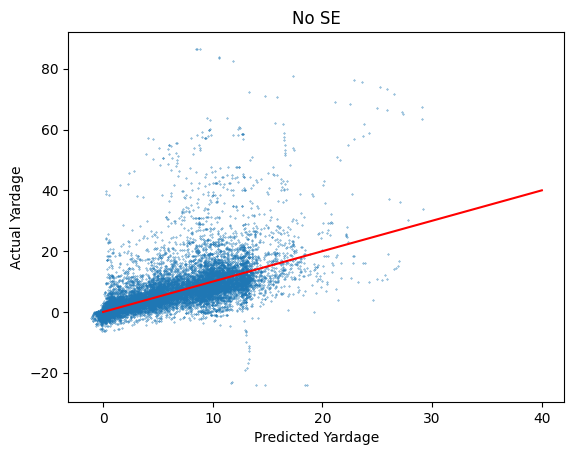

In [69]:
from matplotlib import pyplot as plt 
plt.plot([0,40],[0,40], color='red')
plt.scatter(all_outputs, all_expected, s=0.1, alpha=1.0)
plt.title('No SE')
plt.xlabel('Predicted Yardage')
plt.ylabel('Actual Yardage')

Text(0, 0.5, 'Actual Yardage')

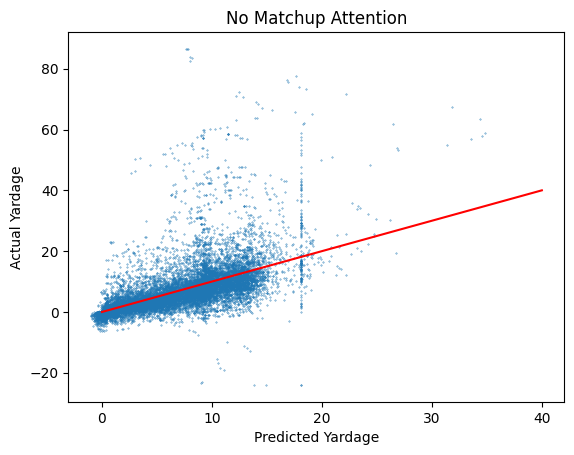

In [73]:
from matplotlib import pyplot as plt 
plt.plot([0,40],[0,40], color='red')
plt.scatter(all_outputs, all_expected, s=0.1, alpha=1.0)
plt.title('No Matchup Attention')
plt.xlabel('Predicted Yardage')
plt.ylabel('Actual Yardage')

Text(0, 0.5, 'Actual Yardage')

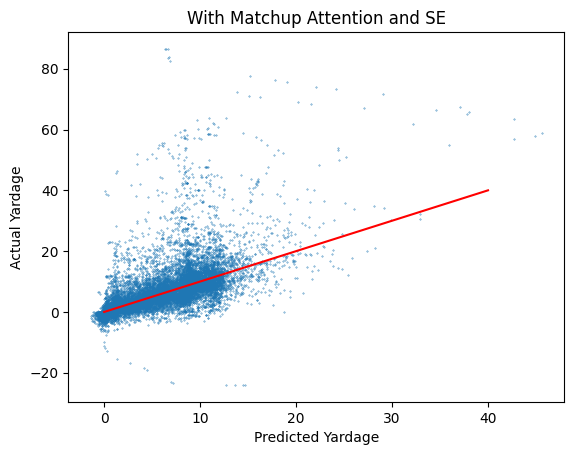

In [78]:
from matplotlib import pyplot as plt 
plt.plot([0,40],[0,40], color='red')
plt.scatter(all_outputs, all_expected, s=0.1, alpha=1.0)
plt.title('With Matchup Attention and SE')
plt.xlabel('Predicted Yardage')
plt.ylabel('Actual Yardage')

Text(0, 0.5, 'Actual Yardage')

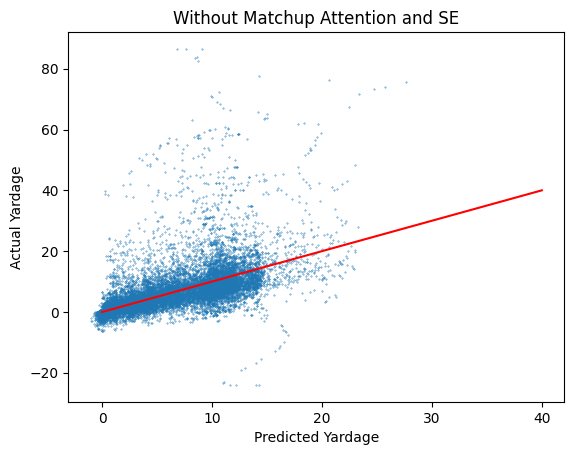

In [82]:
from matplotlib import pyplot as plt 
plt.plot([0,40],[0,40], color='red')
plt.scatter(all_outputs, all_expected, s=0.1, alpha=1.0)
plt.title('Without Matchup Attention and SE')
plt.xlabel('Predicted Yardage')
plt.ylabel('Actual Yardage')

Text(0, 0.5, 'Actual Yardage')

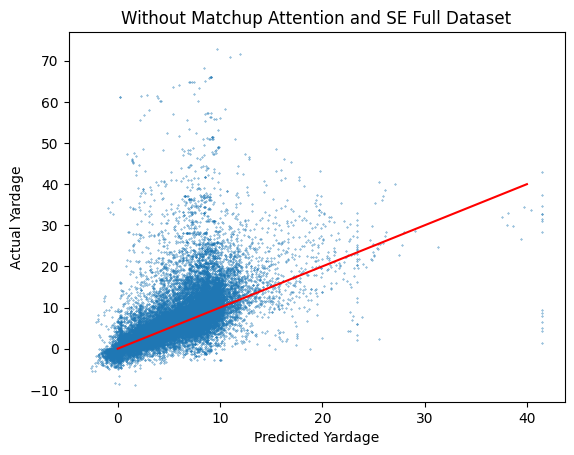

In [49]:
from matplotlib import pyplot as plt 
plt.plot([0,40],[0,40], color='red')
plt.scatter(all_outputs, all_expected, s=0.1, alpha=1.0)
plt.title('Without Matchup Attention and SE Full Dataset')
plt.xlabel('Predicted Yardage')
plt.ylabel('Actual Yardage')

Text(0, 0.5, 'Actual Yardage')

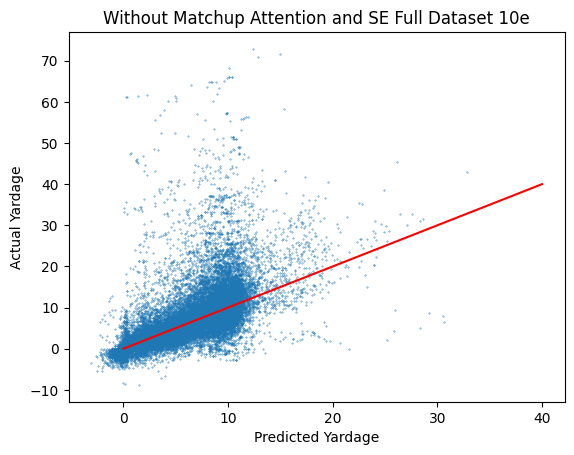

In [59]:
from matplotlib import pyplot as plt 
plt.plot([0,40],[0,40], color='red')
plt.scatter(all_outputs, all_expected, s=0.1, alpha=1.0)
plt.title('Without Matchup Attention and SE Full Dataset 10e')
plt.xlabel('Predicted Yardage')
plt.ylabel('Actual Yardage')

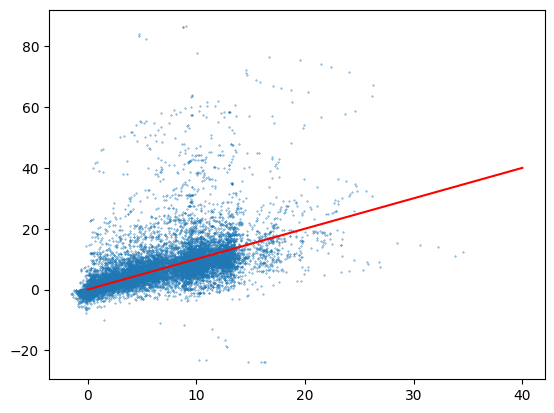

In [30]:
from matplotlib import pyplot as plt 
plt.plot([0,40],[0,40], color='red')
plt.scatter(all_outputs, all_expected, s=0.1,)

In [ ]:
# Preprocessing the data
layers = sorted({name.split('.')[0] for name, _ in layer_gradients})
layer_data = {layer: [] for layer in layers}

for name, value in layer_gradients:
    layer = name.split('.')[0]
    layer_data[layer].append(value)

# Plotting the data
plt.figure(figsize=(15, 8))
for layer, values in layer_data.items():
    plt.plot(values, label=layer)

plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Layer Values Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

ValueError: ignored

In [ ]:
print(outputs, batch_y)

tensor([[0.0876],
        [0.0871]], grad_fn=<SiluBackward0>) tensor([ 2.6000, 15.0300])


In [ ]:
print()

In [ ]:
layer_gradients = []
for name, parameter in model.named_parameters():
    if parameter.grad is not None:
        # Compute the average of the absolute gradients for this layer
        avg_grad = parameter.grad.abs().mean()
        layer_gradients.append((name, avg_grad))

# Sorting the gradients for better visualization
layer_gradients.sort(key=lambda x: x[1], reverse=True)

# Separating names and values for plotting
names, grads = zip(*layer_gradients)

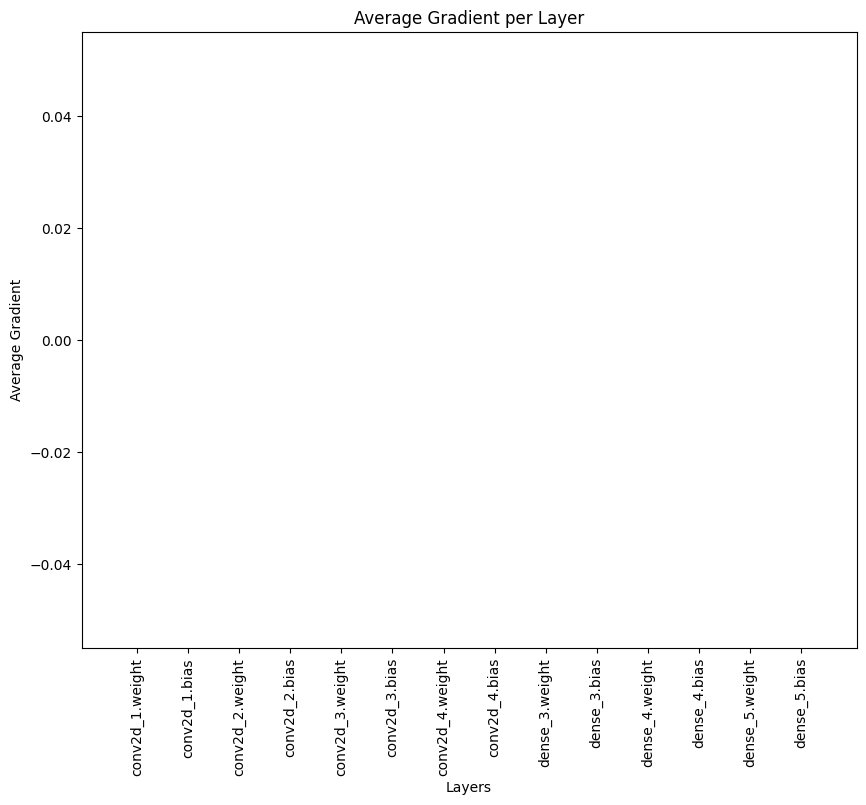

In [ ]:
plt.figure(figsize=(10, 8))
plt.bar(names, grads)
plt.xlabel('Layers')
plt.ylabel('Average Gradient')
plt.title('Average Gradient per Layer')
plt.xticks(rotation=90)  # Rotate names for better readability
plt.show()

In [ ]:
train_dataset[0][0].tolist()

[[[103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531],
  [109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938],
  [108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156],
  [103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625],
  [104.44999694824219,
   104.44999694824219,
   104.44999694824219,
   104.

In [ ]:
train_dataset[0][1]

tensor(101.1500, grad_fn=<SelectBackward0>)